## Boruta: Feature selection method to find all relevant features

There are many ways of doing feature selection. Common feature selection techniques include lasso and using feature importance from tree-based ensemble models. Boruta might be lesser known, but it is a powerful feature selection tool that should be in every data scientist's arsenal. While lasso and feature importance are good, there is a chance that these methods might drop relevant features. Lasso tends to drop correlated variables at random. For example, if variable A and B are highly correlated, whether Lasso keeps A or B is at random and might change at different iterations. Using tree-based model feature importance might also drop relevant variables if the variable is not frequently used in the model whether or not the variable is relevant to the target. If you are interested in finding all relevant variables, Boruta is your answer.

### How does Boruta work?
Boruta is quite simple. From training data, first create copy of all the columns and call them shadow features. For example, if the columns A, B, and C are in the original train data, now the new data columns are A, B, C, shadow_A, shadow_B, and shadow_C. Shuffle rows randomly for all the shadow features. Basically, shadow features are just random features that should have no relationship with the target variable. The reason why we create shadow features will be apparent in the next step.

Next, train a random forest on all the original variables and shadow variables. Calculate feature importance for all variables. "Relevant" features are features that have feature importance higher than the maximum feature importance of all shadow features. *The main idea behind Boruta is that relevant variable should have higher feature importance than the maximum feature importance of random variables.*

Wait a second, didn't I say we might drop relevant variables based on feature importance from a tree-based model like random forest due to random chance? This is correct, and this is where Boruta uses a clever solution to overcome this. The solution is to repeat the previous process of training random forest and finding relevant features multiple times. While a single random forest model might classify irrelevant features as relevant or relevant features as irrelevant, if we do this multiple times (let's say 100), we will be more confident as to which features are actually relevant.  If variable A is deemed relevant 95 out of 100 times, then we are pretty confident A is indeed relevant. If variable C is deemed relevant only 20 out of 100 times, then we are pretty certain C is irrelevant.

That's it! Now we will demonstrate how to run Boruta in Python using Python package `BorutaPy`.

In [1]:
# First, import all necessary packages that will be used in this notebook.
import pandas as pd
import seaborn as sns
from boruta import BorutaPy
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score

If we use a real world data set, we might not know which variables are in fact relevant. If we generate a data set ourselves, we can know for certain which variables are relevant. We will use `make_classification` function from scikit-learn to accomplish this.

Quick note about the parameters:
1. `n_samples` is the number of rows in the dataset.
2. `n_features` is the number of features in the dataset.
3. `n_informative` is the number of relevant features in the dataset. I will use the word informative and relevant interchangeably from now on.
4. `n_redundant` is the number of features that are random linear combination of informative features. While redundant features are not strictly necessary, we will include these to illustrate how different feature selection method act in the presence of multicollinearity. 

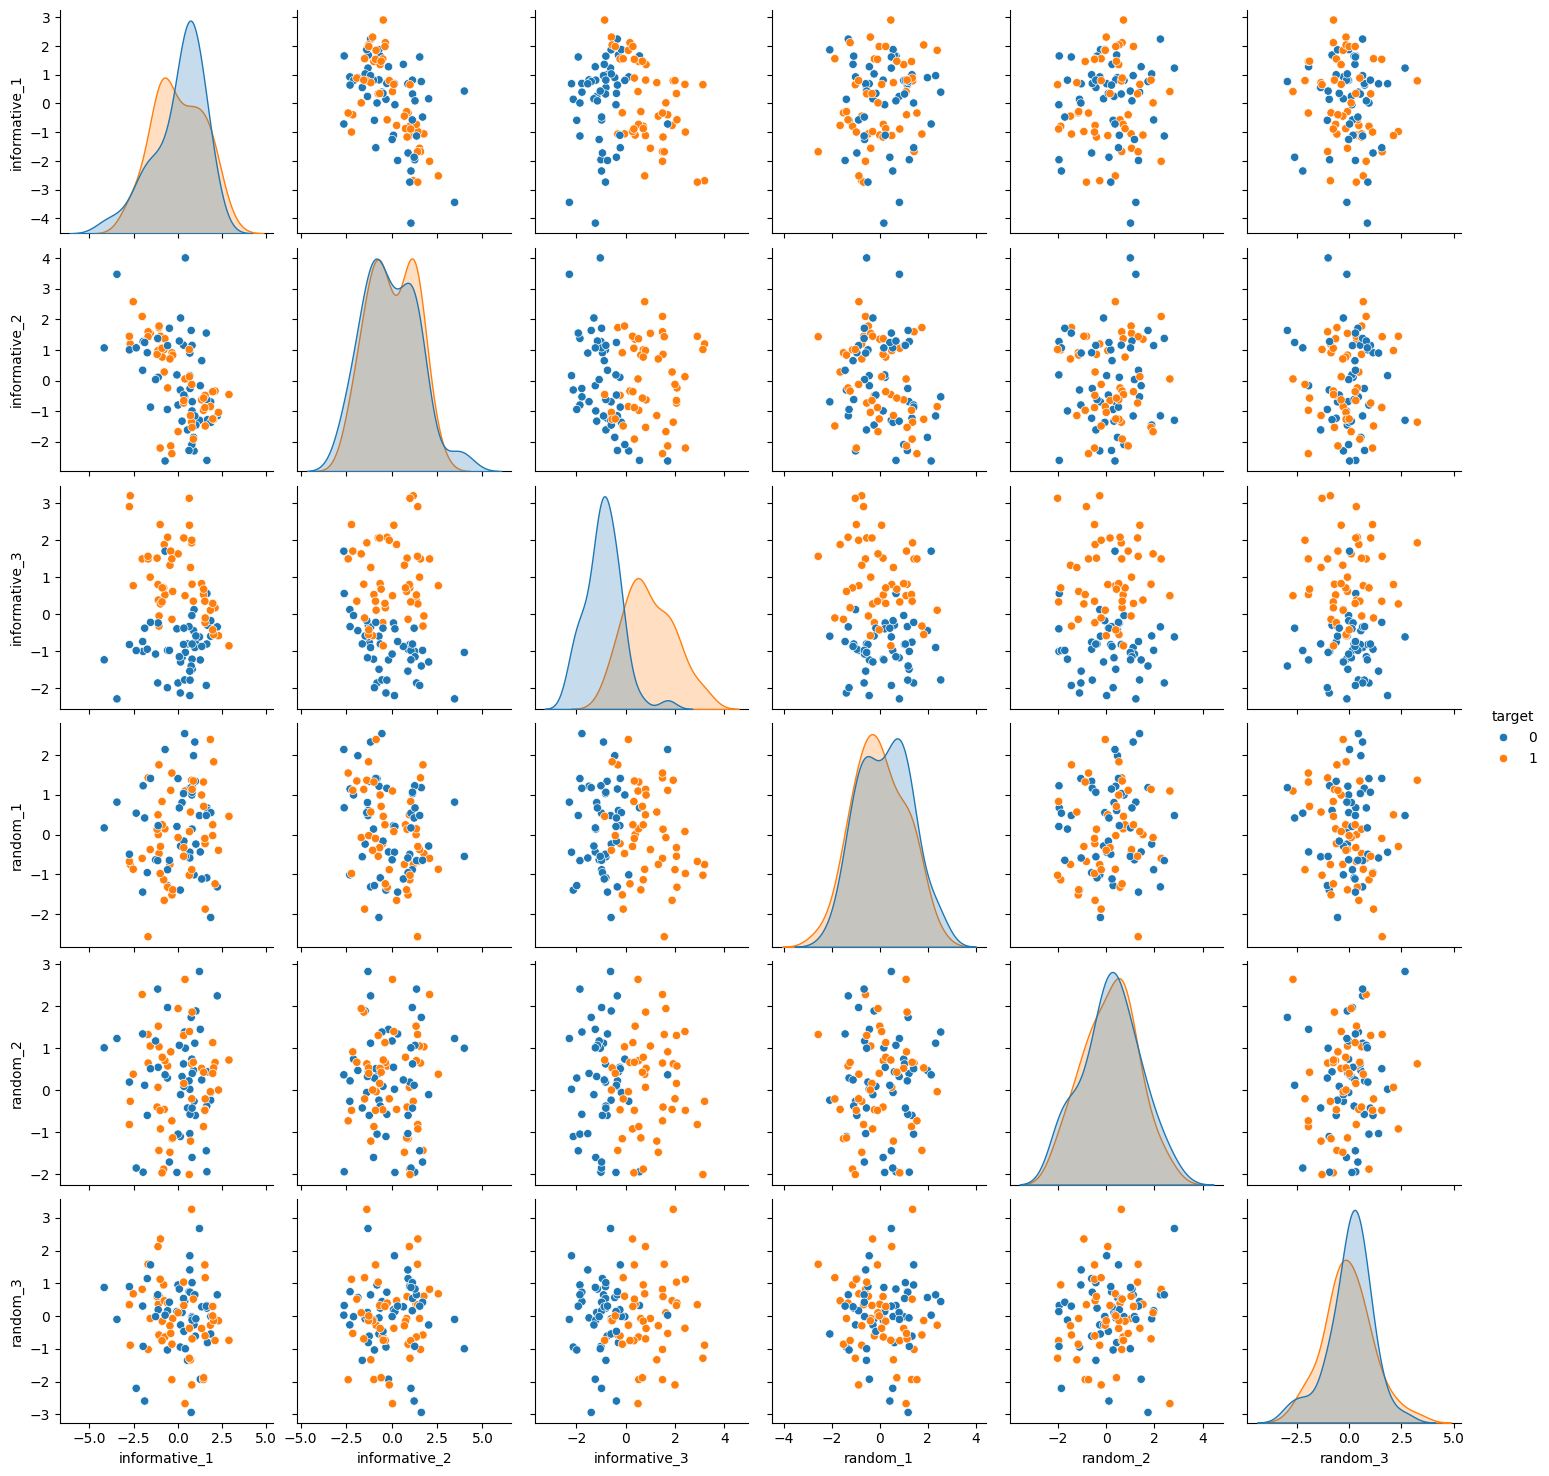

In [2]:
# For reproducibility
random_seed = 17

# Create a function to create classification data
def create_data(n_samples, n_features, n_informative, n_redundant = 0):
    # Generate the dataset
    X, y = make_classification(n_samples = n_samples,
                               n_features = n_features,
                               n_informative = n_informative,
                               n_redundant = n_redundant,
                               n_repeated = 0,
                               n_classes = 2,
                               shuffle = False, # to distinguish which features are informative vs. random
                               random_state = random_seed)
    
    # Turn the data into pandas dataframe
    df = pd.DataFrame(X)
    df['y'] = y

    # Rename columns
    informative_columns = list("informative_{}".format(x) for x in range(1, n_informative + 1))
    random_columns = list("random_{}".format(x) for x in range(1, n_features - n_informative - n_redundant + 1))

    # In case there are redundant features
    if n_redundant != 0:
        redundant_columns = list("redundant_{}".format(x) for x in range(1, n_redundant + 1))
        df.columns = informative_columns + redundant_columns + random_columns + ['target']
    else:
        df.columns = informative_columns + random_columns + ['target']

    return df

# Create a sample dataset for visualization purposes
sample = create_data(n_samples = 100, n_features = 6, n_informative = 3)

# Plot pairwise relationship to confirm first 3 relevant and last 3 random features as constructed
sns.pairplot(sample, hue = 'target')

In [3]:
# Create a data set with 10 features with 5 informative and 5 random
data = create_data(n_samples = 10000, n_features = 10, n_informative = 5, n_redundant = 0)

# Split data into X and y
X = data.drop(columns = 'target')
y = data['target']

# Feature selection using Lasso
lasso = SelectFromModel(LogisticRegression(C = 0.01, penalty = 'l1', solver = 'liblinear', random_state = random_seed))
lasso.fit(X, y)
print("Lasso selected features:", list(X.columns[lasso.get_support(indices = True)]))

# Feature selection using Random Forest
rf = SelectFromModel(RandomForestClassifier(n_jobs = -1, random_state = random_seed))
rf.fit(X, y)
print("Random Forest selected features:", list(X.columns[rf.get_support()]))

# Feature selection using Boruta
boruta = BorutaPy(RandomForestClassifier(n_jobs = -1, random_state = random_seed), n_estimators = 'auto', verbose = 0, random_state = random_seed)
boruta.fit(X, y)
print("Boruta selected features:", list(X.columns[boruta.support_]))

Lasso selected features: ['informative_1', 'informative_2', 'informative_3', 'informative_4', 'informative_5']
Random Forest selected features: ['informative_1', 'informative_2', 'informative_3', 'informative_4', 'informative_5']
Boruta selected features: ['informative_1', 'informative_2', 'informative_3', 'informative_4', 'informative_5']


All three methods were able to correctly identify all the relevant features in this case. Let's see what happens if we introduce multicollinearity using redundant features.

In [4]:
# Create a data set with 15 features with 5 informative, 5 redundant, and 5 random
data2 = create_data(n_samples = 10000, n_features = 15, n_informative = 5, n_redundant = 5)

# Split data into X and y
X2 = data2.drop(columns = 'target')
y2 = data2['target']

# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size = 0.3, random_state = random_seed)

# Feature selection using Lasso
lasso2 = SelectFromModel(LogisticRegression(C = 0.01, penalty = 'l1', solver = 'liblinear', random_state = random_seed))
lasso2.fit(X_train, y_train)
print("Lasso selected features:", list(X_test.columns[lasso2.get_support(indices = True)]))

# Feature selection using Random Forest
rf2 = SelectFromModel(RandomForestClassifier(n_jobs = -1, random_state = random_seed))
rf2.fit(X_train, y_train)
print("Random Forest selected features:", list(X_train.columns[rf2.get_support()]))

# Feature selection using Boruta
boruta2 = BorutaPy(RandomForestClassifier(n_jobs = -1, random_state = random_seed), n_estimators = 'auto', verbose = 0, random_state = random_seed)
boruta2.fit(X_train, y_train)
print("Boruta selected features:", list(X_train.columns[boruta2.support_]))

Lasso selected features: ['informative_3', 'informative_4', 'redundant_1', 'redundant_3', 'redundant_4']
Random Forest selected features: ['informative_1', 'informative_4', 'informative_5', 'redundant_1', 'redundant_3', 'redundant_4', 'redundant_5']
Boruta selected features: ['informative_1', 'informative_2', 'informative_3', 'informative_4', 'informative_5', 'redundant_1', 'redundant_2', 'redundant_3', 'redundant_4', 'redundant_5']


Lasso dropped 3 informative features and kept 3 redundant features. Random forest dropped 2 informative features and 1 redundant feature. Boruta was able to capture all informative and redundant feature as expected!

Now we want to compare how final models perform using only features selected by each method. 

In [5]:
# Only keep features selected by each feature selection method
X_train_lasso = lasso2.transform(X_train)
X_train_rf = rf2.transform(X_train)
X_train_boruta = X_train[X_train.columns[boruta2.support_]]

# Fit logistic regression on all train data
lr_original = LogisticRegression(solver = "liblinear", random_state = random_seed).fit(X_train, y_train)
lr_lasso = LogisticRegression(solver = "liblinear", random_state = random_seed).fit(X_train_lasso, y_train)
lr_rf = LogisticRegression(solver = "liblinear", random_state = random_seed).fit(X_train_rf, y_train)
lr_boruta = LogisticRegression(solver = "liblinear", random_state = random_seed).fit(X_train_boruta, y_train)

# Fit random forest on all train data
rf_original = RandomForestClassifier(n_jobs = -1, random_state = random_seed).fit(X_train, y_train)
rf_lasso = RandomForestClassifier(n_jobs = -1, random_state = random_seed).fit(X_train_lasso, y_train)
rf_rf = RandomForestClassifier(n_jobs = -1, random_state = random_seed).fit(X_train_rf, y_train)
rf_boruta = RandomForestClassifier(n_jobs = -1, random_state = random_seed).fit(X_train_boruta, y_train)

# Only keep features selected by each feature selection method
X_test_lasso = lasso2.transform(X_test)
X_test_rf = rf2.transform(X_test)
X_test_boruta = X_test[X_test.columns[boruta2.support_]]

# Compare AUC of all models
result = pd.DataFrame({"AUC": [roc_auc_score(y_test, lr_original.predict_proba(X_test)[:, 1]),
                               roc_auc_score(y_test, lr_lasso.predict_proba(X_test_lasso)[:, 1]),
                               roc_auc_score(y_test, lr_rf.predict_proba(X_test_rf)[:, 1]),
                               roc_auc_score(y_test, lr_boruta.predict_proba(X_test_boruta)[:, 1]),
                               roc_auc_score(y_test, rf_original.predict_proba(X_test)[:, 1]),
                               roc_auc_score(y_test, rf_lasso.predict_proba(X_test_lasso)[:, 1]),
                               roc_auc_score(y_test, rf_rf.predict_proba(X_test_rf)[:, 1]),
                               roc_auc_score(y_test, rf_boruta.predict_proba(X_test_boruta)[:, 1])],
                       "Feature Selection Method": [None, "Lasso", "Random Forest", "Boruta"] * 2,
                       "Final Model": ["Logistic Regression"] * 4 + ["Random Forest"] * 4})

# Display results with higher AUC first
result.sort_values(by = "AUC", ascending = False)

,AUC,Feature Selection Method,Final Model
7,0.986165,Boruta,Random Forest
4,0.984337,None,Random Forest
6,0.983618,Random Forest,Random Forest
5,0.981724,Lasso,Random Forest
3,0.856458,Boruta,Logistic Regression
2,0.856458,Random Forest,Logistic Regression
1,0.856456,Lasso,Logistic Regression
0,0.856224,None,Logistic Regression


On this specific data, using all relevant features from Boruta was able to yield the highest AUC even though the difference is small. Remember the no free lunch theorem, there are going to be cases where other feature selection methods yield better performance. From my experience using Boruta, it does perform pretty well and is comparable to other popular methods out there.

Thanks for reading!

### Reference:
- Where I first came across Boruta: https://medium.com/towards-data-science/feature-selection-you-are-probably-doing-it-wrong-985679b41456
- Publication: https://www.jstatsoft.org/article/view/v036i11
- BorutaPy on GitHub: https://github.com/scikit-learn-contrib/boruta_py